In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import gensim
import re
from tqdm import tqdm
import numpy as np
import joblib


In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [3]:
la = LabelEncoder()
df["sentiment"] = la.fit_transform(df["sentiment"])
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [4]:
df.drop_duplicates(inplace=True)
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


In [5]:
df.reset_index(inplace=True,drop=True)
df["sentiment"].value_counts()

sentiment
1    24884
0    24698
Name: count, dtype: int64

In [6]:
words = []
ps = PorterStemmer()
stopword = set(stopwords.words("english"))
for i in tqdm(range(len(df["review"]))):
    review = re.sub("[^a-zA-Z]" , " " , df["review"][i])
    review = review.lower()
    review = review.split()
    review = [ps.stem(word) for word in review if word not in stopword]
    # review = ' '.join(review)
    words.append(review)

100%|██████████| 49582/49582 [02:54<00:00, 283.95it/s]


In [8]:
model = gensim.models.Word2Vec(words,window=5,min_count=2)

In [9]:
model.corpus_count

49582

In [11]:
len(model.wv.index_to_key)

41726

In [12]:
model.wv.similar_by_word("one")

[('probabl', 0.5819180011749268),
 ('movi', 0.5312891006469727),
 ('think', 0.47537297010421753),
 ('film', 0.47266510128974915),
 ('possibl', 0.4698962867259979),
 ('definit', 0.4589534103870392),
 ('sure', 0.4563677906990051),
 ('perhap', 0.45439812541007996),
 ('mani', 0.44786757230758667),
 ('singl', 0.44340750575065613)]

In [13]:
def avg_word2vec(doc):
    vector = [model.wv[word] for word in doc if word in model.wv.index_to_key]
    if (len(vector) == 0):
        return np.zeros(model.vector_size)
    else:
        return np.mean(vector,axis=0)

In [14]:
X = []
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i]))

100%|██████████| 49582/49582 [10:44<00:00, 76.95it/s] 


In [15]:
x = np.array(X)
x.shape

(49582, 100)

In [16]:
y = df.iloc[:,-1]
y = np.array(y)

In [17]:
y.shape

(49582,)

In [18]:
x_train , x_test , y_train , y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [19]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)

(14875, 100)
(34707, 100)
(34707,)
(14875,)


In [20]:
from sklearn.svm import SVC
svm = SVC().fit(x_train,y_train)

In [21]:
y_pred = svm.predict(x_test)

In [23]:
print(f"Accuracy : {round(accuracy_score(y_test,y_pred),2)}")
print(classification_report(y_pred,y_test))

Accuracy : 0.87
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      7258
           1       0.88      0.86      0.87      7617

    accuracy                           0.87     14875
   macro avg       0.87      0.87      0.87     14875
weighted avg       0.87      0.87      0.87     14875



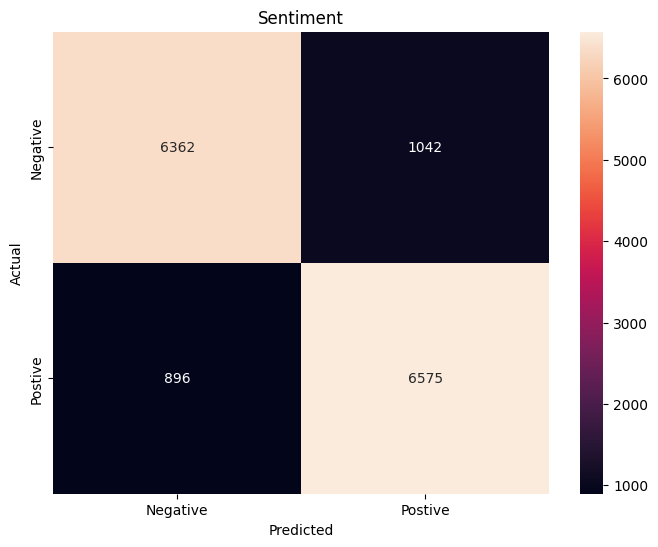

In [24]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt="d",xticklabels=["Negative","Postive"],yticklabels=["Negative","Postive"])
plt.title("Sentiment")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [25]:
def Predition2(the_text):
    review = re.sub('[^a-zA-Z0-9]'," ",the_text)
    review = review.lower()
    review = review.split()
    stopword = set(stopwords.words("english"))
    review = [ps.stem(word) for word in review if not word in stopword]
    
    vectors = avg_word2vec(review)
    vectors = vectors.reshape(1,-1)
    pred = svm.predict(vectors)

    if pred[0] == 1:
        return "Postive"
    else:
        return "Negative"

In [26]:
result1 = Predition2("it's one of the wonderful movies i saw")                        # Sentiment 1
result2 = Predition2("this is film is ugly")                                          # Sentiment 2
result3 = Predition2("it's the one of the worst movie i have been watched")           # Sentiment 3
result4 = Predition2("i love this movie")                                             # Sentiment 4

                                                                # The Acutal Output Sentiment :

print(f'Sentiment 1 : {result1}\n')                                                   # Postive
print(f'Sentiment 2 : {result2}\n')                                                   # Negative
print(f'Sentiment 3 : {result3}\n')                                                   # Negative
print(f'Sentiment 4 : {result4}\n')                                                   # Postive

Sentiment 1 : Postive

Sentiment 2 : Negative

Sentiment 3 : Negative

Sentiment 4 : Postive



In [ ]:
######## Save Models #########

# model.save("word2vec.model")
# joblib.dump(svm,"svm_model.pkl")